In [ ]:
# default_exp nbeats.model

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd
%load_ext autoreload
%autoreload 2

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# N-Beats model

> A basic architecture for time series forecasting.


The approach is based on https://arxiv.org/abs/1905.10437


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *
from fastai2.torch_core import *
from torch.autograd import Variable
from fastseq.all import *

## Blocks

In [ ]:
# export

def linspace(lookback, horizon):
    lin_space = torch.linspace(
        -lookback, horizon, lookback + horizon
    )
    b_ls = lin_space[:lookback]
    f_ls = lin_space[lookback:]
    return b_ls, f_ls


In [ ]:
# export
class Block(Module):
    def __init__(self, fnc_f, fnc_b=None):
        sizes = [self.lookback] + self.layers
        ps = ifnone(self.ps, L([0])*len(self.layers))
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None] # TODO swish
        _layers = [LinBnDrop(sizes[i], sizes[i+1], bn=self.use_bn, p=p, act=a)
                       for i,(p,a) in enumerate(zip(ps, actns))]
        self.layers = nn.Sequential(*_layers)
        self.att = LinBnDrop(sizes[-1], 1)
        if self.share_thetas:
            self.theta_f_fc = self.theta_b_fc = LinBnDrop(sizes[-1], self.thetas_dim)
        else:
            self.theta_b_fc = LinBnDrop(sizes[-1], self.thetas_dim)
            self.theta_f_fc = LinBnDrop(sizes[-1], self.thetas_dim)
            
        b, f = linspace(self.lookback, self.horizon)
        self.backcast_linspace = Variable(b, requires_grad=False).to(self.device)
        self.forecast_linspace = Variable(f, requires_grad=False).to(self.device)
        self.fnc_f = fnc_f
        self.fnc_b = ifnone(fnc_b, fnc_f)
        self.to(self.device)
        self.y_range = getattr(self,'y_range', None)
        
    def forward(self, x):
        # trend
        x = self.layers(x)
        att = torch.sigmoid(self.att(x))
        theta_b = self.apply_range(self.theta_b_fc(x)) * att
        theta_f = self.apply_range(self.theta_f_fc(x)) * att
        backcast = self.fnc_b(theta_b, self.backcast_linspace)
        forecast = self.fnc_f(theta_f, self.forecast_linspace)
        return {'b':backcast,'f': forecast, 'theta': att*(theta_b + theta_f), 'attention': att}
    
    def apply_range(self, x): 
        if self.y_range is None:
            return x
        return (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]

In [ ]:
# export
def bias_model(thetas, t):
    r= torch.mm(t[None,:].float().T,thetas[:,0][None,:]).T 
    if thetas.shape[-1]==2:
        return r+thetas[:,1][:,None]
    return r

class BiasBlock(Block):
    def __init__(
        self, layers:L, device, thetas_dim=2, lookback=10, horizon=5, use_bn=True, bn_final=False, ps:L=None
    ):
        share_thetas=True
        assert thetas_dim <= 2, f"thetas_dim for BaisBlock must be < than 2, is now {thetas_dim}"
        store_attr(self,"device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas" ) 
        self.layers=L(self.layers[-1])
        super().__init__(bias_model)        
        self.to(device)

In [ ]:
mdl = BiasBlock([256], device=torch.device('cuda'), lookback=100, horizon=10)
dct = mdl(torch.randn(64,100).to(torch.device('cuda')))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))
test_eq(dct['theta'].shape,(64,2))
test_eq(dct['attention'].shape,(64,1))

In [ ]:
# export
class LinearD(nn.Linear):        
    def forward(self, x, *args, **kwargs):
        return super().forward(x)
        
class GenericBlock(Block):
    def __init__(
        self, layers:L, thetas_dim:int, device, lookback=10, horizon=5, use_bn=True, bn_final=False, ps:L=None, share_thetas=True, y_range=[-.5,.5]
    ):
        store_attr(self,"y_range,device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas" ) 
        super().__init__(LinearD(self.thetas_dim, self.horizon),LinearD(self.thetas_dim, self.lookback))        
        self.to(device)
        

In [ ]:
mdl = GenericBlock([256], thetas_dim=4, device=torch.device('cuda'), lookback=100, horizon=10)
dct = mdl(torch.randn(64,100).to(torch.device('cuda')))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))

In [ ]:
# export

def seasonality_model(thetas, t):
    p = thetas.size()[-1]
    assert p < 10, "thetas_dim is too big."
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    s1 = [torch.cos(2 * np.pi * i * t)[None,:] for i in range(p1)] # H/2-1
    s2 = [torch.sin(2 * np.pi * i * t)[None,:] for i in range(p2)]
    S = torch.cat([*s1, *s2])
    return thetas.mm(S)

class SeasonalityBlock(Block):
    def __init__(
        self, layers:L, thetas_dim:int, device, lookback=10, horizon=5, use_bn=True, bn_final=False, ps:L=None, share_thetas=True,y_range=[-.5,.5]
    ):       
        store_attr(self,"y_range,device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas" ) 
        super().__init__(seasonality_model )        
        self.to(device)

In [ ]:
mdl = SeasonalityBlock([256], thetas_dim=4, device=torch.device('cuda'), lookback=100, horizon=10)
dct = mdl(torch.randn(64,100).to(torch.device('cuda')))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))

In [ ]:
# export
def trend_model(thetas, t):
    p = thetas.size()[-1]
    assert p <= 4, "thetas_dim is too big."
    a = [torch.pow(t, i)[None,:] for i in range(p)]
    T = torch.cat(a).float()
    return thetas.mm(T)

class TrendBlock(Block):
    def __init__(
        self, layers:L, device, thetas_dim, lookback=10, horizon=5, use_bn=True, bn_final=False, ps:L=None, share_thetas=True, y_range=[-.05,.05]
    ):
        store_attr(self,"y_range,device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas" ) 
        super().__init__(trend_model)        
        self.to(device)

In [ ]:
mdl = TrendBlock([256], thetas_dim=4, device=torch.device('cuda'), lookback=100, horizon=10)
dct = mdl(torch.randn(64,100).to(torch.device('cuda')))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))
test_eq(dct['theta'].shape,(64,4))

In [ ]:
# export

# not pritty but still works better
def select_block(o):
    if isinstance(o,int):
        if o == 0:
            return SeasonalityBlock
        elif o == 1:
            return TrendBlock
        elif o == 2:
            return BaisBlock
        else:
            return GenericBlock
    else:
        if o == 'seasonality':
            return SeasonalityBlock
        elif o == 'trend':
            return TrendBlock
        elif o =='bias':
            return BiasBlock
        else:
            return GenericBlock

In [ ]:
# export
class NBeatsNet(Module):
    def __init__(
        self,
        device,
        stack_types=('bias', 'trend', 'seaonality'),
        nb_blocks_per_stack=3,
        horizon=5,
        lookback=10,
        thetas_dim=None,
        share_weights_in_stack=False,
        layers= [200,100],
    ):
        super(NBeatsNet, self).__init__()
        thetas_dim = ifnone(thetas_dim,[3 if 'bias' not in o else 2 for o in stack_types  ])
        stack_types= L(stack_types)
        store_attr(self,'device,horizon,lookback,layers,nb_blocks_per_stack,share_weights_in_stack,stack_types,thetas_dim,device')
        self.stacks = []
        self._str = "| N-Beats\n"
        
        self.bn = BatchNorm(lookback, ndim=2)        
        stacks = OrderedDict()        
        for stack_id in range(len(self.stack_types)):
            
            stacks[str(self.stack_types[stack_id]) + str(stack_id)] = self.create_stack(stack_id)
        self.stacks = nn.Sequential(stacks)
        
    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        self._str += f"| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_stack})\n"
        
        blocks = []
        for block_id in range(self.nb_blocks_per_stack):
            block_init = select_block(stack_type)
            if self.share_weights_in_stack and block_id != 0:
                block = blocks[-1]  # pick up the last one when we share weights.
            else:
                block = block_init(
                    layers = self.layers,
                    thetas_dim = self.thetas_dim[stack_id],
                    device = self.device,
                    lookback = self.lookback,
                    horizon = self.horizon,
                )
            self._str += f"     | -- {block}\n"
            blocks.append(block)
            
        return nn.Sequential(*blocks)

    def forward(self, backcast):
        backcast = backcast.view([-1,backcast.shape[-1]])
        forecast = torch.zeros(
            size=(backcast.size()[0], self.horizon,)
        )  # maybe batch size here.
        
        dct = defaultdict(dict)
        for stack_id, names in enumerate(self.stacks.named_children()):
            name = names[0]
            for block_id in range(len(self.stacks[stack_id])):
                dct[name+'_'+str(block_id)] = self.stacks[stack_id][block_id](backcast)
                backcast = backcast.to(self.device) - dct[name+'_'+str(block_id)]['b']
                forecast = forecast.to(self.device) + dct[name+'_'+str(block_id)]['f']
        
        return forecast[:,None,:], backcast[:,None,:], dct



In [ ]:
mdl = NBeatsNet(torch.device('cpu'), stack_types=('seaonality'), )
f, b, dct = mdl(torch.randn(64,1,10))
print(f.shape,b.shape)
print([(stack, o['theta'].mean(0)) for stack,o in dct.items()])

torch.Size([64, 1, 5]) torch.Size([64, 1, 10])
[('seaonality0_0', tensor([ 0.0062, -0.0015,  0.0153], grad_fn=<MeanBackward1>)), ('seaonality0_1', tensor([ 0.0067,  0.0042, -0.0009], grad_fn=<MeanBackward1>)), ('seaonality0_2', tensor([ 0.0006, -0.0035,  0.0229], grad_fn=<MeanBackward1>))]


## Callback 

In [ ]:
# export
class NBeatsTrainer(Callback):
    "`Callback` that stores extra outputs of N-Beats training and make the output only the forecast."
    def begin_train(self): 
        self.out = defaultdict(dict)
    def begin_validate(self): 
        self.out = defaultdict(dict)
        
    def after_pred(self):
        self.pred[2]['total_b'] = self.pred[1] 
        self.out = concat_dct(self.pred[2], self.out)   
        self.learn.pred = self.pred[0]


Train:89; Valid: 33; Test 3


epoch,train_loss,valid_loss,time
0,9.292189,11.425602,00:00
1,7.463478,3.433837,00:00
2,5.235984,2.329948,00:00
3,4.077403,1.795337,00:00
4,3.423396,1.398367,00:00
5,2.985035,1.046377,00:00
6,2.632636,0.787556,00:00
7,2.321826,0.501721,00:00
8,2.048974,0.929679,00:00
9,1.820713,0.898654,00:00


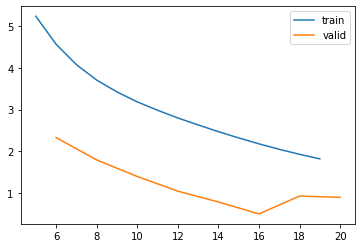

In [ ]:
horizon, lookback = 7,10
items = L(np.arange(-5,100)[None,:],np.arange(500,550)[None,:],np.arange(-110,-56)[None,:]).map(tensor)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=1, after_batch = NormalizeTS()
                               )

mdl = NBeatsNet(device = data.train.device, stack_types=('trend','seaonality'), horizon=horizon, lookback=lookback)
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, 
                cbs=L(NBeatsTrainer())
               )

learn.fit(10,.1)
learn.recorder.plot_loss()

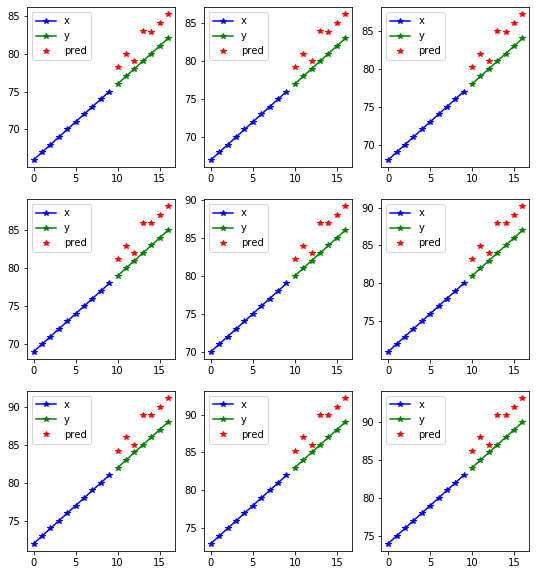

In [ ]:
learn.show_results()

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 07_interpret.ipynb.
Converted 10_metrics.ipynb.
Converted 11_nbeats.metrics.ipynb.
Converted index.ipynb.
